In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')

#### corin's attempts to fit random forest to data

   Unnamed: 0        Date   Open    High     Low  Close  Adj.Close  Volume  \
0           1  2017-01-03  2.511  2.5180  2.4480  2.450      2.450       0   
1           2  2017-01-04  2.456  2.4740  2.4340  2.452      2.452       0   
2           3  2017-01-05  2.439  2.4430  2.3460  2.368      2.368       0   
3           4  2017-01-06  2.339  2.4250  2.3390  2.418      2.418       0   
4           5  2017-01-08  2.363  2.4085  2.3535  2.397      2.397       0   
5           6  2017-01-09  2.387  2.3920  2.3680  2.376      2.376       0   
6           7  2017-01-10  2.390  2.3920  2.3630  2.379      2.379       0   
7           8  2017-01-11  2.372  2.3980  2.3290  2.370      2.370       0   
8           9  2017-01-12  2.336  2.3630  2.3090  2.361      2.361       0   
9          10  2017-01-13  2.336  2.4310  2.3360  2.380      2.380       0   

        Vol  
0  0.014096  
1  0.008150  
2  0.020255  
3  0.018052  
4  0.011550  
5  0.005042  
6  0.006099  
7  0.014597  
8  0.011558  
9

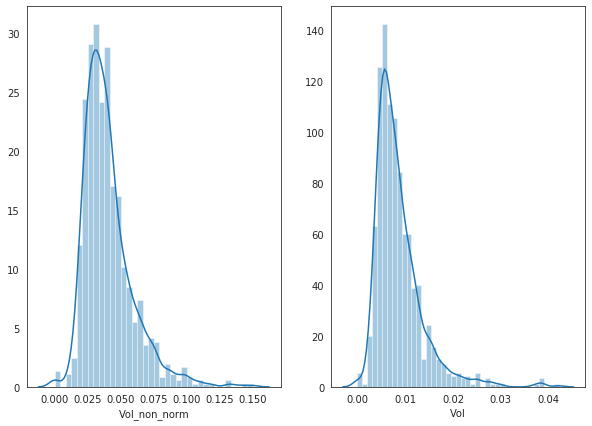

In [56]:
bonds_10 = pd.read_csv('../bonds/adjusted^TNX.csv')
bonds_10['Vol'] = (bonds_10['High'] - bonds_10['Low']) / (bonds_10['High'] + bonds_10['Low'])
print(bonds_10.head(10))

bonds_10['Vol_non_norm'] = bonds_10['High'] - bonds_10['Low']

fig, ax = plt.subplots(1, 2, figsize=(10,7))
sns.distplot(bonds_10['Vol_non_norm'], ax=ax[0])
sns.distplot(bonds_10['Vol'], ax=ax[1])
#plt.title('Histogram of Daily Delta in 10 Year Bonds')

#plt.show()

In [17]:
predictors = pd.read_csv('../tweets/cleaned_tweets_by_day')

#### so we can quickly pull out the desired columns later
pred_cols = predictors.columns.values
pred_cols = list(filter(lambda a: not re.match("Unnamed", a), pred_cols))
pred_cols = list(filter(lambda a: not re.match("Date", a), pred_cols))

predictors.head(10)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,num_words,num_hashtags,is_retweet,favorite_count,retweet_count,num_mentions,keyword_China,...,keyword_FBI,keyword_rivals,keyword_MiddleEast,keyword_Ukraine_scandal,keyword_economy,keyword_disaster,year,month,day,Date
0,2017.0,1.0,20.0,181.0,3.0,1588729,1588729,362593,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2017.0,1.0,20.0,2017-01-20
1,2017.0,1.0,21.0,67.0,0.0,467521,467521,103818,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,1.0,21.0,2017-01-21
2,2017.0,1.0,22.0,91.0,0.0,949408,949408,184236,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,1.0,22.0,2017-01-22
3,2017.0,1.0,23.0,24.0,0.0,177839,177839,26750,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2017.0,1.0,23.0,2017-01-23
4,2017.0,1.0,24.0,79.0,1.0,495813,495813,86707,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2017.0,1.0,24.0,2017-01-24
5,2017.0,1.0,25.0,166.0,0.0,1112361,1112361,240014,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,1.0,25.0,2017-01-25
6,2017.0,1.0,26.0,188.0,0.0,970602,970602,194173,16.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2017.0,1.0,26.0,2017-01-26
7,2017.0,1.0,27.0,107.0,2.0,841537,841537,168114,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,1.0,27.0,2017-01-27
8,2017.0,1.0,28.0,95.0,1.0,465730,465730,83334,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,1.0,28.0,2017-01-28
9,2017.0,1.0,29.0,130.0,0.0,968933,968933,226253,3.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2017.0,1.0,29.0,2017-01-29


In [50]:
def make_score_RF(meta_df, predictor_df, response_var, pred_cols, design_mat_outfile):
    design = pd.merge(left=meta_df, right=predictor_df, on='Date')
    design.to_csv(design_mat_outfile)
    
    X, Xt, y, yt = train_test_split(design[pred_cols], design[response_var], test_size=0.3, random_state=42)
    
    rf = RandomForestRegressor(n_estimators=int(round(np.sqrt(len(pred_cols))))).fit(X,y)
   
    print(f"train is {rf.score(X,y):.3f}")
    print(f"test is  {rf.score(Xt,yt):.3f}")
    
    return(rf)

In [61]:
pred_bonds_10 = pd.merge(left=bonds_10, right=predictors, on='Date') # default is INNER join which is what we want
#### now these have the same indices!
pred_bonds_10.to_csv("data/keywords_bonds_model_data.csv")

X, Xt, y, yt = train_test_split(pred_bonds_10[pred_cols], pred_bonds_10['Vol'], 
                                test_size=0.3,
                               random_state=42)

In [25]:
rf = RandomForestRegressor().fit(X, y)
print(f"train is {rf.score(X,y):.3f}")
print(f"test is  {rf.score(Xt,yt):.3f}")

train is 0.853
test is  0.286


/home/priyav/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [57]:
pred_cols = predictors.columns.values
pred_cols = list(filter(lambda a: not re.match("Unnamed", a), pred_cols))
pred_cols = list(filter(lambda a: not re.match("Date", a), pred_cols))
make_score_RF(bonds_10, predictors, 'Vol', pred_cols, "data/keywords_model_data.csv")
make_score_RF(bonds_10, predictors, 'Vol_non_norm', pred_cols, "data/keywords_model_data.csv")


train is 0.840
test is  0.300
train is 0.773
test is  -0.148


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [59]:
# Use sentiment
predictors_sentiment = pd.read_csv('../tweets/data/grouped_daily_tweets_sentiment.csv')
predictors_sentiment.head()
make_score_RF(bonds_10, predictors_sentiment, 'Vol', predictors_sentiment.columns[:-1], 'data/sentiment_model_data.csv')
make_score_RF(bonds_10, predictors_sentiment, 'Vol_non_norm', predictors_sentiment.columns[:-1], 'data/sentiment_model_data.csv')


train is 0.817
test is  -0.112
train is 0.809
test is  -0.248


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=11,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [63]:
# Word2Vec encodings for predictors
encodings = pd.read_csv('../tweets/data/word2vec_doc_embeddings.by_date.csv')

metadata_bond_cols = ['num_words', 'num_hashtags', 'is_retweet', 'favorite_count', 'retweet_count', 'num_mentions', 'Vol', 'Vol_non_norm','Date']
meta_df = pred_bonds_10[metadata_bond_cols]
predictors_embed = encodings.drop(columns=['retweet_count_sum'])
pred_encodings_cols = metadata_bond_cols[:len(metadata_bond_cols)-3] + ["col_{}_sum".format(i) for i in range(300)]

make_score_RF(meta_df, predictors_embed, 'Vol', pred_encodings_cols, 'data/word2vec_embeddings_bonds_model_data.csv')

make_score_RF(meta_df, predictors_embed, 'Vol_non_norm', pred_encodings_cols, 'data/word2vec_embeddings_bonds_model_data.csv')

#pred_encodings_bonds_10 = pd.merge(left=pred_bonds_10[metadata_bond_cols], 
#                                   right=encodings.drop(columns=['retweet_count_sum']), on='Date')

#pred_encodings_bonds_10.to_csv("data/word2vec_embeddings_bonds_model_data.csv")



#X_embed, Xt_embed, y_embed, yt_embed = train_test_split(pred_encodings_bonds_10[pred_encodings_cols],
#                                pred_encodings_bonds_10['Vol'],
#                                test_size=0.3,
#                                random_state=42)


train is 0.818
test is  0.044
train is 0.819
test is  -0.129


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=17,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [55]:
rf_embed = RandomForestRegressor(n_estimators=int(round(np.sqrt(301)))).fit(X_embed, y_embed)
print(f"train is {rf_embed.score(X_embed,y_embed):.3f}")
print(f"test is  {rf_embed.score(Xt_embed,yt_embed):.3f}")

train is 0.844
test is  0.057


Simple topic model

In [84]:
predictors = pd.read_csv('../tweets/data/topic_model_simple_weights.by_day.csv')
make_score_RF(bonds_10, predictors, 'Vol', predictors.drop(columns='Date').columns, 'data/topic_model_simple_weights_model_data.csv')

# now predict with metadata about retweets
metadata_bond_cols = ['num_words', 'num_hashtags', 'is_retweet', 'favorite_count', 'retweet_count', 'num_mentions', 'Vol', 'Vol_non_norm','Date']
meta_df = pred_bonds_10[metadata_bond_cols]
make_score_RF(meta_df, 
              predictors, 
              'Vol',
              predictors.drop(columns='Date').columns.values.tolist() + meta_df.drop(columns=['Date', 'Vol', 'Vol_non_norm']).columns.values.tolist(), 
              'data/topic_model_simple_weights_model_data.csv')


train is 0.646
test is  -0.110
train is 0.690
test is  0.061


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)